<a href="https://colab.research.google.com/github/3zero69/-/blob/main/%ED%95%B8%EC%A6%88%EC%98%A8%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_CH4_%EB%AA%A8%EB%8D%B8_%ED%9B%88%EB%A0%A8_p_157_202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CHAPTER 4. 모델 훈련



1. 선형 회귀
- 직접 계산할 수 있는 공식을 사용하여 훈련 세트에 가장 잘 맞는 모델 파라미터(즉, 훈련 세트에 대해 비용 함수를 최소화하는 모델 파라미터)를 해석적으로 구함
- 경사 하강법(GD)이라 불리는 반복적인 최적화 방식을 사용하여 모델 파라미터를 조금씩 바꾸면서 비용 함수를 훈련 세트에 대해 최소화. 결국에는 앞의 방법과 동일한 파라미터로 수렴.
- 경사 하강법의 변종으로 2부에서 신경망을 공부할 때 계속 사용하게 될 배치 경사 하강법, 미니 배치 경사 하강법, 확률적 경사 하강법 도 살펴보겠습니다.

2. 다항회귀 - 비선형 데이터셋에 훈련시킬 수 있는 조금 더 복잡한 모델
- 선형 회귀보다 파라미터가 많아서 훈련 데이터에 과대적합 되기 더 쉬움
- 훈련 세트의 과대적합을 감소시킬 수 있는 규제 기법

3. 로지스틱 회귀 & 소프트맥스 회귀 - 분류 작업에 널리 사용

## 4.1 선형 회귀

* (1장) 삶의 만족도에 대한 간단한 선형 회귀 모델
${삶의 만족도 = theata_0 + theata_1 * 1인당_GDP }$ 
  - 입력 특성인 '1인당_GDP' 에 대한 선형함수
  - theata0과 theata1 이 모델 파라미터

- 선형 모델
  - 입력 특성의 가중치 합과 편향 (또는 절편) 이라는 상수를 더해 예측을 만듦

### 4.1.1 정규방정식

- **정규 방정식** : 비용 함수를 최소화하는 theata 값을 찾기 위한 해석적 방법 (바로 결과를 얻을 수 있는 수학 공식)

  - theata hat : 비용 함수를 최소화하는 theata 값
  - y 는 y(1) 부터 y(m) 까지 포함하는 타깃 벡터

공식을 테스트 해보자

In [ ]:
# 선형처럼 보이는 데이터 생성

import numpy as np

X = 2 * np.random.rand(100,1)
y = 4 + 3 * X + np.random.randn(100,1)

In [ ]:
#@title 정규방정식을 사용해 theata hat 계산
#
# y = 4 + 3*x1 + 가우시안_잡음
#
# 넘파이 선형대수 모듈(np.linalg) 의 inv() 함수로 역행렬 계산 /dot() 메서드로 행렬 곱셈

X_b = np.c_[np.ones((100,1)), X] # 모든 샘플에 x0 = 1 추가
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

theta_best

## 잡음 때문에 원래 함수의 파라미터를 정확하게 재현하지 못함

array([[4.11449915],
       [2.94788842]])

In [ ]:
#@title theata hat 을 사용해 예측

X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)),X_new]

y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 4.11449915],
       [10.01027599]])

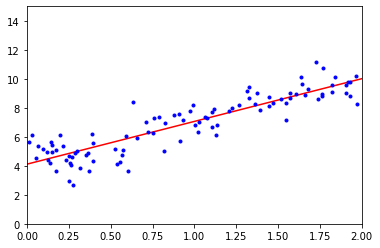

In [ ]:
# 모델의 예측 그래프에 나타내기

import matplotlib.pyplot as plt

plt.plot(X_new, y_predict, "r-")
plt.plot(X,y,"b.")
plt.axis([0,2,0,15])
plt.show()

In [ ]:
#@title 사이킷런에서 선형 회귀 수행

from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)

LinearRegression()

In [ ]:
lin_reg.intercept_, lin_reg.coef_

(array([4.11449915]), array([[2.94788842]]))

In [ ]:
lin_reg.predict(X_new)

array([[ 4.11449915],
       [10.01027599]])

In [ ]:
#@title LinearRegression 클래스 scipy.linalg.lstsq() 기반, 함수 직접 호출
#
# theta hat = X^+ * y (X^+ : 유사역행렬)

theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.11449915],
       [2.94788842]])

In [ ]:
#유사역행렬 직접 구하기

np.linalg.pinv(X_b).dot(y)


array([[4.11449915],
       [2.94788842]])

### 4.1.2 계산 복잡도

* 정규방정식은 (n+1) * (n+1) 크기가 되는 ${X^TX}$ 의 역행렬을 계산  
* 역행렬을 계산하는 계산 복잡도


## 4.2 경사 하강법

여러 종류의 문제에서 최적의 해법을 찾을 수 있는 일반적인 최적화 알고리즘

* 아이디어 : 비용 함수를 최소화하기 위해 반복해서 파라미터 조정

  - 파라미터 벡터 theta 에 대해 비용 함수의 현재 그레이디언트를 계산
  - 그리고 그레이디언트가 감소하는 방향으로 진행
  - 그레이디언트가 0이 되면 최솟값에 도달한 것

* 방법
  : theta 를 임의의 값으로 시작해서 (무작위 초기화) 한 번에 조금씩 비용 함수가 감소되는 방향으로 진행하여 알고리즘이 최솟값에 수렴할 때까지 점진적으로 향상시킴

* 주요 파라미터 : 스텝의 크기
  - 학습률 하이퍼파라미터로 결정됨
   - 학습률이 너무 작으면 알고리즘이 수렴하기 위해 반복을 많이 진행해야 하므로 시간이 오래 걸림
   - 학습률이 너무 크면 골짜기를 가로질러 반대편으로 건너뛰게 되어 더 높은 곳으로 올라가게 될지도 모름
     - 이는 알고리즘을 더 큰 값으로 발산하게 만들어 적절한 해법을 찾지 못하게 함

* 경사 하강법의 문제점
1. 무작위 초기화 때문에 알고리즘이 왼쪽에서 시작하면 전역 최솟값보다 덜 좋은 지역 최솟값에 수렴
2. 알고리즘이 오른쪽에서 시작하면 평탄한 지역을 지나기 위해 시간이 오래 걸리고 일찍 멈추게 되어 전역 최솟값에 도달하지 못함

* 선형 회귀를 위한 MSE 비용 함수 
 - 어떤 두 점을 선택해 선을 그어도 곡선을 가로지르지 않는 볼록 함수
   - 지역 최솟값이 없고, 하나의 전역 최솟값만 있음
   - 연속된 함수이고 기울기가 갑자기 변하지 않음
 - 경사 하강법이 전역 최솟값에 가깝게 접근할 수 있다는 것을 보장

* 비용 함수는 대부분 그릇 모양을 하고 있지만,  특성들의 스케일이 매우 다르면 길쭉한 모양일 수 있음
 

### 4.2.1 배치 경사 하강법
* 편도함수 : theta 가 조금씩 변경될 때 비용 함수가 얼마나 바뀌는지 계산

스텝 알고리즘 구현

In [ ]:
eta = 0.1 # 학습률
n_iterations = 100
m = 100

theta = np.random.randn(2,1)  # 무작위 초기화

for iteration in range(n_iterations):
  gradients=2/m * X_b.T.dot(X_b.dot(theta)-y)
  theta=theta-eta*gradients

In [ ]:
theta

## 정규 방정식으로 찾은 값과 정확히 같음 - 경사 하강법 완벽히 작동

array([[4.07324656],
       [2.98402422]])

학습률 
- 학습률이 너무 낮으면
 - 알고리즘은 최적점에 도달하겠지만 시간이 오래 걸림
- 학습률이 적당하면
 - 반복 몇 번 만에 이미 최적점에 수렴
- 학습률이 너무 높으면
 - 알고리즘이 널뛰면서 스텝마다 최적점에서 점점 더 멀어져 발산


적절한 학습률을 찾으려면,
- 그리드 탐색 사용
  - 그러나, 수렴하는 데 너무 오래 걸리는 모델을 막기 위해 반복 횟수 제한해야 함

반복 횟수는 어떻게 지정?
- 너무 작으면 
  - 최적점에 도달하기 전에 알고리즘이 멈춤
- 너무 크면 
  - 모델 파라미터가 더는 변하지 않는 동안 시간 낭비

- 해결책 :
 - 반복 횟수를 아주 크게 지정하고 그레이디언트 벡터가 아주 작아지면 (벡터의 노름이 어떤 값(허용오차) 보다 작아지면)
 - 경사 하강법이 최솟값에 도달한 것이므로 알고리즘 중지  


###4.2.2 확률적 경사 하강법

배치 경사 하강법의 문제점
 - 매 스텝에서 전체 훈련 세트를 사용해 그레이디언트를 계싼
 - 훈련 세트가 커지면 매우 느려짐

반대로, 확률적 경사 하강법은
 - 매 스텝에서 한 개의 샘플을 무작위로 선택하고, 그 하나의 샘플에 대한 그레이디언트를 계산
 - 매 반복에서 다뤄야 할 데이터가 매우 적기 때문에 한 번에 하나의 샘플을 처리하면 알고리즘이 훨씬 빠름

그러나, 확률적(즉, 무작위) 이기 때문에
- 배치 경사 하강법 보다 훨씬 불안정함 
- 비용 함수가 최솟값에 다다를 때까지 부드럽게 감소하지 않고 위아래로 요동치면서 평균적으로 감소
  - 시간이 지나면 최솟값에 매우 근접하나, 요동이 지속되면서 최솟값에 안착하지 못함
  - 알고리즘이 멈출 때 좋은 파라미터가 구해지겠지만, 최적치는 아님 

비용 함수가 매우 불규칙할 경우 
- 알고리즘이 지역 최솟값을 건너 뛸 수도 있도록 도와주므로 
- 확률적 경사 하강법이 배치 경사 하강법보다 전역 최솟값을 찾을 가능성 높음

**정리**

무작위성은 
- 지역 최솟값에서 탈출시켜줘서 좋지만
- 알고리즘을 전역 최솟값에 다다르지 못하게 한다는 점에서는 좋지 않음

해결책
- 학습률을 점진적으로 감소시키는 것
  - 시작할 때는 학습률을 크게 하고 
    - 수렴을 빠르게, 지역 최솟값에 빠지지 않게
  - 점차 작게 줄여서 알고리즘이 전역 최솟값에 도달하게 함

cf . 학습 스케줄 : 매 반복에서 학습률을 결정하는 함수  

In [ ]:
#@title 간단한 학습 스케줄을 사용한 확률적 경사 하강법의 구현

n_epochs=50
t0, t1=5, 50 #학습 스케줄 하이퍼 파라미터

def learning_schedule(t):
  return t0/(t+t1)

theta = np.random.randn(2,1) #무작위 초기화

for epoch in range(n_epochs):
  for i in range(m):                        
    random_index=np.random.randint(m)
    xi=X_b[random_index:random_index+1]
    yi=y[random_index:random_index+1]
    gradients=2*xi.T.dot(xi.dot(theta)-yi)
    eta=learning_schedule(epoch*m+i)
    theta=theta-eta*gradients

한 반복에서 m 번 되풀이 됨, 이때 각 반복을 **에포크** 라고 함

In [ ]:
theta

array([[4.10574766],
       [2.93626374]])

알고리즘이 에포크 마다 모든 샘플을 사용하게 하려면, 훈련 세트를 섞은 후 (입력 특성과 레이블을 동일하게 섞어야 함) , 차례대로 하나씩 선택하고 다음 에포크에서 다시 섞는 식의 방법 사용

In [ ]:
#@title 사이킷런 SGD 방식 선형 회귀

from sklearn.linear_model import SGDRegressor
sgd_reg=SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())
     

SGDRegressor(eta0=0.1, penalty=None)

In [ ]:
sgd_reg.intercept_, sgd_reg.coef_

## 정규방정식으로 구한 것과 매우 비슷한 값

(array([4.05240744]), array([2.91509955]))

### 4.2.3 미니배치 경사 하강법

각 스텝에서 전체 훈련 세트(배치 경사 하강법 처럼) 나 하나의 샘플(확률적 경사 하강법 처럼) 을 기반으로 그레이디언트를 계산하는 것이 아니라,

**미니배치**라 부르는 임의의 작음 샘플 세트에 대해 그레이디언트를 계산

- 확률적 경사 하강법에 비해 행렬 연산에 최적화된 하드웨어, 특히 GPU 를 사용해서 얻는 성능 향상

미니배치를 어느 정도 크게 하면, 파라미터 공간에서 SGD 보다 덜 불규칙하게 움직임 
 - 결국 미니배치 경사 하강법이 SGD 보다 최솟값에 더 가까이 도달
 - 하지만, 지역 최솟값에서 빠져나오기는 더 힘듦

#### 세 가지 경사 하강법 비교
각 알고리즘이 훈련 과정동안 파라미터 공간에서 움직인 경로

- 모두 최솟값 근처에 도달
- 배치 경사 하강법의 경로: 실제로 최솟값에서 멈춤
  - 그러나, 매 스텝에서 많은 시간이 소요
- 확률적 경사 하강법 & 미니배치 경사 하강법의 경로 : 근처에서 맴돌고 있음 
  - 적절한 학습 스케줄을 사용하면 최솟값에 도달함

## 4.3 다항 회귀

가지고 있는 데이터가 단순한 직선보다 복잡한 형태인 경우

- 다항회귀 : 비선형데이터를 학습하는 데 선형 모델을 사용 할 수 있음
  - 각 특성의 거듭제곱을 새로운 특성으로 추가하고, 
  - 확장된 특성을 포함한 데이터셋에 선형 모델을 훈련

In [ ]:
# 2차 방정식 비선형 데이터 생성

m=100
X=6*np.random.rand(m, 1)-3
y=0.5*X**2+X+2+np.random.randn(m,1) # 약간의 잡음 포함

In [ ]:
# 훈련 데이터 변환 - 각 특성을 제곱하여 새로운 특성으로 추가

from sklearn.preprocessing import PolynomialFeatures
poly_features=PolynomialFeatures(degree=2, include_bias=False)
X_poly=poly_features.fit_transform(X) 
X[0]

array([0.13229871])

In [ ]:
X_poly[0] ## 원래 특성 X와 이 특성의 제곱 포함

array([0.13229871, 0.01750295])

In [ ]:
# 확장된 훈련 데이터에 LInear Regression 적용
lin_reg=LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.07049069]), array([[0.93639248, 0.44528025]]))

특성이 여러 개일 때 다항 회귀는 이 특성 사이의 관계를 찾을 수 있음 (일반적인 선형 회귀 모델에서는 하지 못함)
- PolynomialFeatures 가 주어진 차수까지 트성 간의 모든 교차항을 추가함

## 4.4 학습 곡선

고차 다항 회귀를 적용하면,
- 보통의 선형 회귀에서보다 훨씬 더 훈련 데이터에 잘 맞추려고 함
- 단순 선형 모델, 2차 모델과 비교
  - 고차 다항 회귀 모델은 훈련 샘플에 가능한 가까이 가려고 구불구불하게 나타남
   - 심각하게 훈련 데이터에 과대적합
  - 반면, 선형 모델은 과소적합



얼마나 복잡한 모델을 사용할지 어떻게 결정?

어떻게 모델이 데이터에 과대적합 또는 과소적합 되었는지 판단?

- 2장. 모델의 일반화 성능을 추정하기 위해 교차 검증 사용
  - 훈련 데이터의 성능이 좋지만, 교차 검증 점수가 나쁘면 모델이 과대적합
  - 양 쪽 모두 좋지 않으면 과소적합

- 3장. **학습 곡선**
  - 훈련 세트와 검증 세트의 모델 성능을 훈련 세트 크기(또는 훈련 반복)의 함수로 나타냄
  - 훈련 세트에서 크기가 다른 서브 세트를 만들어 모델을 여러번 훈련

In [ ]:
#@title 모델의 학습 곡선을 그리는 함수 : plot_learning_curves(model, X, y)

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
  X_train, X_val, y_train, y_val=train_test_split(X, y, test_size=0.2)
  train_errors, val_errors=[], []
  for m in range(1, len(X_train)):
    model.fit(X_train[:m], y_train[:m])
    y_train_predict=model.predict(X_train[:m])
    y_val_predict=model.predict(X_val)
    train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))
  plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label='훈련 세트')
  plt.plot(np.sqrt(val_errors), 'b-', linewidth=3, label='검증 세트')

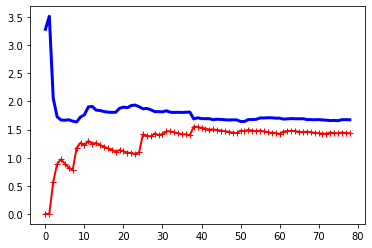

In [ ]:
#단순 선형 회귀 모델의 학습 곡선

lin_reg=LinearRegression()
plot_learning_curves(lin_reg, X, y)

> 과소적합 모델 
1. 훈련 데이터의 성능 : 그래프가 0에서 시작하므로,
           - 훈련 세트에 하나 혹은 두개의 샘플이 있을 땐 모델이 완벽하게 작동
           - 훈련 세트에 샘플이 추가됨에 따라 잡음도 있고 비선형이기 때문에 모델이 훈련 데이터를 완벽하게 학습하는 것이 불가능해짐
           - 곡선이 어느 정도 평탄해질 때까지 오차가 계속 상승
           - 훈련 세트에 샘플이 추가되어도 평균 오차가 크게 나아지거나 나빠지지 않음
2. 검증 데이터에 대한 모델의 성능
         - 모델이 적은 수의 훈련 샘플로 훈련될 때는 제대로 일반화 될 수 없어서 검증 오차가 초기에 매우 큼
         - 훈련 샘플이 추가됨에 따라 학습이 되고 검증 오차가 천천히 감소
         - 그러나, 선형 회귀의 직선은 데이터를 잘 모델링 할 수 없으므로 오차의 감소가 완만해져 훈련 세트의 그래프와 가까워짐
3. 과소적합 모델의 전형적인 모습 
- 두 곡선이 수평한 구간을 만들고 꽤 높은 오차에서 매우 가까이 근접


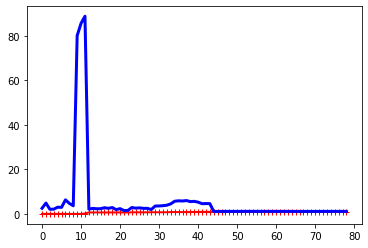

In [ ]:
#@title 10차 다항 회귀 모델의 학습 곡선

from sklearn.pipeline import Pipeline

polynomial_regression=Pipeline([('poly_features', PolynomialFeatures(degree=10, include_bias=False)), ('lin_reg', LinearRegression())])
plot_learning_curves(polynomial_regression, X, y)
     

> - 훈련 데이터의 오차가 선형 회귀 모델보다 훨씬 낮음
- 두 곡선 사이의 공간 : 훈련 데이터에서의 모델 성능이 검증 데이터에서보다 훨씬 낫다는 의미
  - 과대적합 모델의 특징
  - 더 큰 훈련 세트를 사용하면 두 곡선이 점점 가까워짐

## 4.5 규제가 있는 선형 모델

과대 적합을 감소시키는 좋은 방법은 모델을 규제하는 것(즉, 모델을 제한)

- 자유도를 줄이면 데이터에 과대적합 되기 더 어려워짐
  - 다항 회귀 모델을 규제하는 방법은 다항식의 차수를 감소시키는 것
- 선형 회귀 모델에서는 보통 모델의 가중치를 제한함으로써 규제를 가함

### 4.5.1 릿지 회귀

규제가 추가된 선형 회귀 버전 
* 규제항이 비용 함수에 추가됨
  - 학습 알고리즘을 데이터에 맞추는 것 뿐만 아니라 모델의 가중치가 가능한 작게 유지되도록
  - 규제항은 훈련하는 동안에만 비용 함수에 추가됨
    - 모델의 훈련이 끝나면 모델의 성능을 규제가 없는 성능 지표로 평가
  - 하이퍼파라미터 ${a}$ : 모델을 얼마나 많이 규제할 지 조절
    - ${a=0}$ 이면, 릿지 회귀는 선형 회귀와 같아짐
    - ${a}$ 가 아주 크면 모든 가중치가 거의 0에 가까워지고  결국 데이터의 평균을 지나는 수평선이 됨
    - ${a}$ 를 증가시킬수록 직선에 가까워짐, 모델의 분산은 줄지만 편향은 커지게 됨

In [ ]:
#@title 정규방정식을 사용한 릿지 회귀 적용
from sklearn.linear_model import Ridge
ridge_reg=Ridge(alpha=1, solver='cholesky') # 행렬 분해를 사용하여 변형한 방정식
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[4.5704289]])

In [ ]:
sgd_reg=SGDRegressor(penalty='l2') # penalty :사용할 규제 지정, SGD의 비용 함수에 가중치 벡터의 노름의 제곱을 2로 나눈 규제항을 추가하게 만듦
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([4.56241859])

### 4.5.2 라쏘 회귀

릿지 회귀처럼 비용 함수에 규제항을 더하지만, 노름의 제곱을 2로 나눈 것 대신 가중치 벡터의 노름을 사용

In [ ]:
from sklearn.linear_model import Lasso
lasso_reg=Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([4.51880268])

In [ ]:
sgd_reg=SGDRegressor(penalty='l1')
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([4.56372417])

### 4.5.3 엘라스틱넷

릿지 회귀와 라쏘 회귀를 절충한 모델
- 규제항: 릿지와 회귀의 규제항을 단순히 더해서 사용
- 혼합 정도는 혼합 비율을 사용해 조절
  - ${gamma}$ = 0  : 릿지 회귀와 동일
  - ${gamma}$ = 1 : 라쏘 회귀와 동일


보통의 선형 회귀(즉, 규제가 없는 모델) /릿지 /라소 /엘라스틱넷 을 언제 사용해야 하는가
  - 적어도 규제가 약간 있는 것이 대부분의 경우에 좋으므로 일반적으로 평범한 선형 회귀는 피해야 함
  - 릿지가 기본이 되지만, 쓰이는 특성이 몇 개 뿐이라고 의심되면 라쏘나 엘라스틱넷이 나음
    - 불필요한 특성의 가중치를 0으로 만들어 줌
    - 특성 수가 훈련 샘플 수보다 많거나 특성 몇 개가 강하게 연관되어 있을 때는 보통 라쏘가 문제를 일으키므로 라쏘보다는 엘라스틱넷을 선호

In [ ]:
#@title 엘라스틱넷 예제

from sklearn.linear_model import ElasticNet
elastic_net=ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])  

array([4.52490378])

### 4.5.4 조기 종료

반복적인 학습 알고리즘을 규제하는 아주 색다른 방식
- 조기 종료:  검증 에러가 최솟값에 도달하면 바로 훈련을 중지시키는 것
  - 에포크가 진행됨에 따라 알고리즘이 점차 학습되어 훈련 세트에 대한 예측 에러(RMSE)와 검증 세트에 대한 예측 에러가 줄어듦
  - 그러나, 잠시후 감소하던 검증 에러가 멈추었다가 다시 상승함 
    - 모델이 훈련 데이터에 과대적합 되기 시작 하는 것을 의미
- 검증 에러가 최소에 도달하는 즉시 훈련을 멈추는 것

In [ ]:
#@title 조기 종료 구현 코드

from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

X_train, X_val, y_train, y_val=train_test_split(X, y, test_size=0.2)

#데이터 준비
poly_scaler=Pipeline([
    ('poly_features', PolynomialFeatures(degree=90, include_bias=False)),
    ('std_scaler', StandardScaler())
])
X_train_poly_scaled=poly_scaler.fit_transform(X_train)
X_val_poly_scaled=poly_scaler.transform(X_val)

sgd_reg=SGDRegressor(max_iter=1, tol=-np.inf, warm_start=True, penalty=None, learning_rate='constant', eta0=0.0005)
# warm_start=True : fit()메서드가 호출될 때 처음부터 다시 시작하지 않고 이전 모델 파라미터에서 훈련을 이어감

minimum_val_error=float('inf')
best_epoch=None
best_model=None
for epoch in range(1000):
  sgd_reg.fit(X_train_poly_scaled, y_train) #훈련을 이어서 진행
  y_val_predict=sgd_reg.predict(X_val_poly_scaled)
  val_error=mean_squared_error(y_val, y_val_predict)
  if val_error

SyntaxError: ignored

## 4.6 로지스틱 회귀

어떤 회귀 알고리즘은 분류에서도 사용할 수 있음

로지스틱 회귀(로짓 회귀) 는 샘플이 특정 클래스에 속할 확률을 추정하는데 널리 사용
  - 예) 이메일이 스팸일 확률은 얼마인가?
    - 추정 확률이 50% 넘으면 모델은 그 샘플이 해당 클래스에 속한다고 예측  : 이진 분류기
     - 레이블 1 = 양성 클래스
    - 아니면 클래스에 속하지 않는다고 예측
      - 레이블 0 - 음성 클래스

### 4.6.1 확률 추정

로지스틱 회귀는 실제 어떻게 작동하는가?
- 선형 회귀 모델과 같이 로지스틱 회귀 모델은 입력 특성의 가중치 합을 계산 (그리고 편향을 더함)
- 대신 선형 회귀처럼 바로 결과를 출력하지 않고 결괏값의 로지스틱을 출력

로지스틱은 0과 1 사이의 값을 출력하는 시그모이드 함수
- 로지스틱 회귀 모델이 샘플 x 가 양성 클래스에 속할 확률을 추정하면 이에 대한 예측 y_hat 을 쉽게 구할 수 있음

### 4.6.2 훈련과 비용 함수

훈련의 목적 : 양성 샘플에 대해서는 높은 확률을 추정하고 음성 샘플에 대해서는 낮은 확률을 추정하는 모델의 파라미터 벡터를 찾는 것



### 4.6.3 결정 경계

붓꽃 데이터 분류기 : Iris-Versicolor 종을 감지하는 분류기

In [ ]:
# 데이터 로드
from sklearn import datasets
iris=datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [ ]:
X=iris['data'][:, 3:] #꽃잎의 너비
y=(iris['target']==2).astype(np.int) #1 Iris-Virginica면 1, 아니면 0

<ipython-input-32-d3eecaceb385>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y=(iris['target']==2).astype(np.int) #1 Iris-Virginica면 1, 아니면 0


In [ ]:
#로지스틱 회귀 모델 훈련
from sklearn.linear_model import LogisticRegression

log_reg=LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

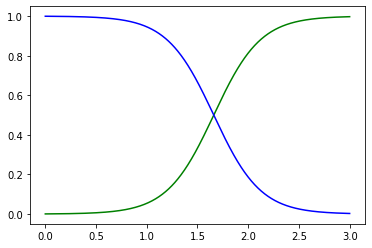

In [ ]:
#꽃잎의 너비가 0~3cm인 꽃에 대해 모델이 추정 확률을 계산
X_new=np.linspace(0,3,1000).reshape(-1,1)
y_proba=log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], 'g-', label='Iris virginica')
plt.plot(X_new, y_proba[:, 0], 'b-', label='Not Iris virginica')

## 꽃잎의 너비는 1.4 ~ 2.5 cm 에 분포
## 반면, 다른 붓꽃은 일반적으로 꽃잎 너비가 더 작아 0.1 ~ 1.8cm 에 분포



약간의 중첩되는 부분이 있음
- 꽃잎 너비가 2cm 이상인 꽃은 분류기가 iris-verginica 라고 강하게 확신(이 클래스에 대해 높은 확률 출력)
- 반면, 1cm 아래면 iris-verginica 가 아니라고 강하게 확신

이 두 극단 사이에서는 분류가 확실하지 않음

In [ ]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

### 4.6.4 소프트맥스 회귀

로지스틱 회귀 모델은 여러개의 이진 분류기를 훈련시켜 연결하지 않고 직접 다중 클래스를 지원하도록 일반화 될 수 있음

In [ ]:
X=iris['data'][:, (2,3)] #꽃잎 길이, 꽃잎 너비
y=iris['target']

softmax_reg=LogisticRegression(multi_class='multinomial', solver='lbfgs', C=10)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial')

In [ ]:
#꽃잎 길이가 5, 너비가 2인 붓꽃 발견
softmax_reg.predict([[5,2]])

array([2])

In [ ]:
softmax_reg.predict_proba([[5,2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])